In [23]:
import numpy as np
import matplotlib.pyplot as plt
from bigtree import Node

class ReachAvoidStayRRT:
    def __init__(self, x_init, K, delta_q, unsafe_regions, target, tau=0.1, seed=None, example_name="Example"):
        if seed is not None:
            np.random.seed(seed)  # Set random seed for reproducibility
        self.tau = tau
        self.A = np.array([[1, tau, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 1, tau],
                           [0, 0, 0, 1]])
        self.B = np.array([[0.5 * tau**2, 0],
                           [tau, 0],
                           [0, 0.5 * tau**2],
                           [0, tau]])
        self.x_init = np.array(x_init)
        self.K = K
        self.delta_q = delta_q
        self.nodes = [Node("0", state=self.x_init)]
        self.u_bounds = np.array([[-1, 1], [-1, 1]])
        self.target = np.array(target)
        self.unsafe_regions = [np.array(region) for region in unsafe_regions]
        self.solution_path = []
        self.node_counter = 1
        self.example_name = example_name  # Add example_name attribute

    def is_within_bounds(self, x):
        return (0 <= x[0] <= 5 and 0 <= x[2] <= 5 and -1 <= x[1] <= 1 and -1 <= x[3] <= 1)

    def is_safe(self, x):
        return all(not (np.all(region[0] <= x) and np.all(x <= region[1])) for region in self.unsafe_regions)

    def is_target(self, x):
        return np.all(self.target[0] <= x) and np.all(x <= self.target[1])

    def rand_control(self):
        return np.random.uniform(self.u_bounds[:, 0], self.u_bounds[:, 1])

    def apply_dynamics(self, x, u):
        return self.A @ x + self.B @ u

    def build_rrt(self):
        for step in range(self.K * 2):
            x_rand = np.random.uniform([0, -1, 0, -1], [5, 1, 5, 1])
            x_near = min(self.nodes, key=lambda node: np.linalg.norm(node.state - x_rand))
            x_near_val = x_near.state
            
            if (self.target[0, 0] <= x_near_val[0] <= self.target[1, 0] and 
                self.target[0, 2] <= x_near_val[2] <= self.target[1, 2]):
                x_vel, y_vel = x_near_val[1], x_near_val[3]
                state_magnitude = np.linalg.norm(x_near_val)
                u_x = -1 if abs(x_vel) >= 0.1 else (-state_magnitude if x_vel > 0 else state_magnitude)
                u_y = -1 if abs(y_vel) >= 0.1 else (-state_magnitude if y_vel > 0 else state_magnitude)
                u = np.clip(np.array([u_x, u_y]), self.u_bounds[:, 0], self.u_bounds[:, 1])
            else:
                u = self.rand_control()
                
            x_new = self.apply_dynamics(x_near_val, u)
            
            if self.is_within_bounds(x_new) and self.is_safe(x_new):
                new_node = Node(str(self.node_counter), state=x_new, parent=x_near)
                self.nodes.append(new_node)
                self.node_counter += 1
                if self.is_target(x_new):
                    self.solution_path.append(new_node)
                    break

            # # Print the step progress and the example name
            # if step % (self.K // 10) == 0:  # Print progress every 10% of K
            #     print(f"Currently Running: {self.example_name}, Step {step}/{self.K * 2}")
                
        return self.nodes

    def plot_tree_and_solution(self):

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        # Plot tree edges
        for node in self.nodes:
            if node.parent:
                x_near = node.parent.state
                x_new = node.state
                plt.plot([x_near[0], x_new[0]], [x_near[2], x_new[2]], 'bo-', markersize=3, 
                         label='Tree Edges' if node == self.nodes[1] else None)
        
        # Plot unsafe regions
        for i, region in enumerate(self.unsafe_regions):
            plt.fill([region[0, 0], region[1, 0], region[1, 0], region[0, 0]],
                     [region[0, 2], region[0, 2], region[1, 2], region[1, 2]],
                     color='red', alpha=0.5, label='Unsafe Regions' if i == 0 else None)
        
        # Plot target region
        plt.fill([self.target[0, 0], self.target[1, 0], self.target[1, 0], self.target[0, 0]],
                 [self.target[0, 2], self.target[0, 2], self.target[1, 2], self.target[1, 2]],
                 color='blue', alpha=0.5, label='Target')
        
        # Set axis limits to show full playing field unless points are outside
        x_coords = [node.state[0] for node in self.nodes]
        y_coords = [node.state[2] for node in self.nodes]
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)
        
        plt.xlim(0, 5 if x_max <= 5 and x_min >= 0 else max(5, x_max) if x_max > 5 else min(0, x_min))
        plt.ylim(0, 5 if y_max <= 5 and y_min >= 0 else max(5, y_max) if y_max > 5 else min(0, y_min))
        
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.title("Reach-Avoid-Stay RRT")
        plt.legend()
        plt.grid()
        #plt.show()

    
        if not self.solution_path:
            print("No valid solution found reaching the safe zone.")
            return
        
        plt.subplot(1, 2, 2)
        # Plot unsafe regions
        for i, region in enumerate(self.unsafe_regions):
            plt.fill([region[0, 0], region[1, 0], region[1, 0], region[0, 0]],
                     [region[0, 2], region[0, 2], region[1, 2], region[1, 2]],
                     color='red', alpha=0.5, label='Unsafe Regions' if i == 0 else None)
        
        # Plot target region
        plt.fill([self.target[0, 0], self.target[1, 0], self.target[1, 0], self.target[0, 0]],
                 [self.target[0, 2], self.target[0, 2], self.target[1, 2], self.target[1, 2]],
                 color='blue', alpha=0.5, label='Target')
        
        # Plot solution path
        node = self.solution_path[0]
        first_segment = True
        while node:
            x = node.state
            if node.parent:
                x_parent = node.parent.state
                plt.plot([x_parent[0], x[0]], [x_parent[2], x[2]], 'go-', markersize=5, 
                         label='Solution Path' if first_segment else None)
                first_segment = False
            node = node.parent
        
        # Set axis limits to show full playing field unless points are outside
        x_coords = [node.state[0] for node in self.nodes]
        y_coords = [node.state[2] for node in self.nodes]
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)
        
        plt.xlim(0, 5 if x_max <= 5 and x_min >= 0 else max(5, x_max) if x_max > 5 else min(0, x_min))
        plt.ylim(0, 5 if y_max <= 5 and y_min >= 0 else max(5, y_max) if y_max > 5 else min(0, y_min))
        
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.title("Solution Path to Safe Zone")
        plt.legend()
        plt.grid()
        plt.show()
    
    def plot_velocity_and_input(self):
        times = np.arange(len(self.nodes)) * self.tau
        velocities_x = [node.state[1] for node in self.nodes]
        velocities_y = [node.state[3] for node in self.nodes]
        inputs_x = [self.u_bounds[0, 0] if node.parent is None else (node.state[1] - node.parent.state[1]) / self.tau for node in self.nodes]
        inputs_y = [self.u_bounds[1, 0] if node.parent is None else (node.state[3] - node.parent.state[3]) / self.tau for node in self.nodes]

        plt.figure(figsize=(12, 5))

        # Velocity vs. Time
        plt.subplot(1, 2, 1)
        plt.plot(times, velocities_x, 'r-', label="Velocity X")
        plt.plot(times, velocities_y, 'b-', label="Velocity Y")
        plt.ylim(-1.1, 1.1)
        plt.xlabel("Time (s)")
        plt.ylabel("Velocity")
        plt.title("Velocity vs. Time")
        plt.legend()
        plt.grid()

        # Input vs. Time
        plt.subplot(1, 2, 2)
        plt.plot(times, inputs_x, 'r--', label="Input X")
        plt.plot(times, inputs_y, 'b--', label="Input Y")
        plt.xlabel("Time (s)")
        plt.ylabel("Input")
        plt.title("Input vs. Time")
        plt.legend()
        plt.grid()
        plt.ylim(-1.1, 1.1)
        plt.show()

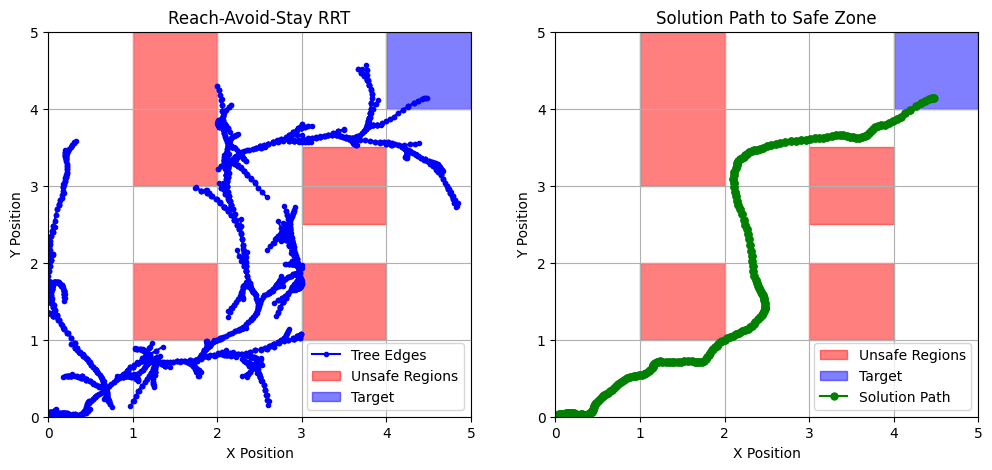

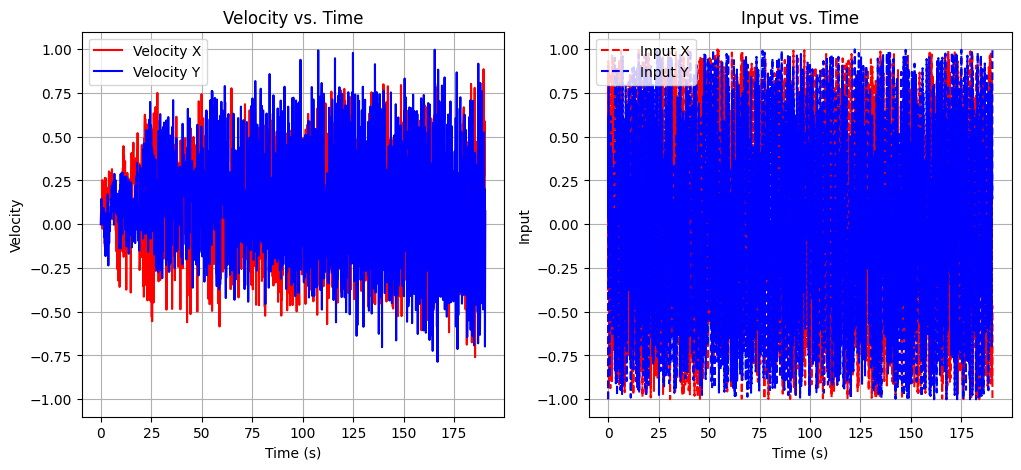

In [24]:
# Original Example
original_unsafe = [
    [[1, -1, 1, -1], [2, 1, 2, 1]],
    [[1, -1, 3, -1], [2, 1, 5, 1]],
    [[3, -1, 1, -1], [4, 1, 2, 1]],
    [[3, -1, 2.5, -1], [4, 1, 3.5, 1]]
]
original_target = [[4, -0.1, 4, -0.1], [5, 0.1, 5, 0.1]]
rrt = ReachAvoidStayRRT(x_init=[0, 0, 0, 0], K=1500, delta_q=0.1, 
                        unsafe_regions=original_unsafe, target=original_target, 
                        tau=0.1, seed=42, example_name="Original Example")
tree = rrt.build_rrt()
rrt.plot_tree_and_solution()
rrt.plot_velocity_and_input()

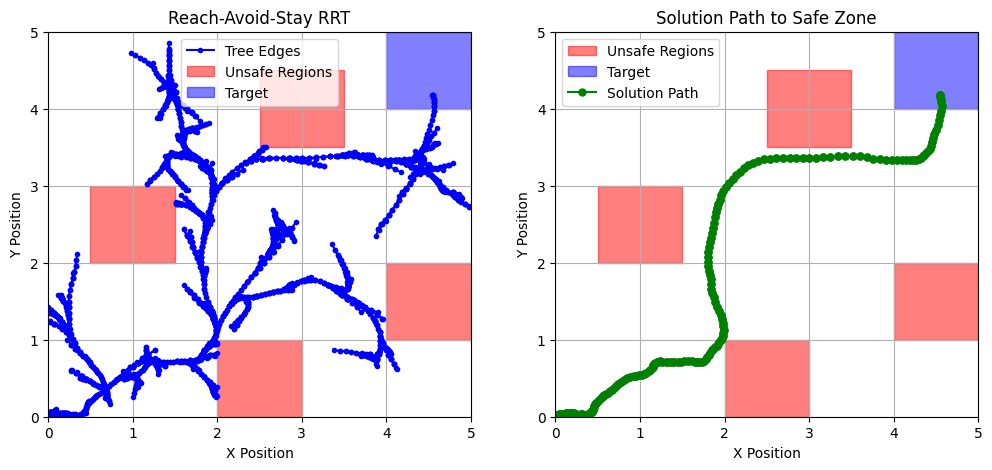

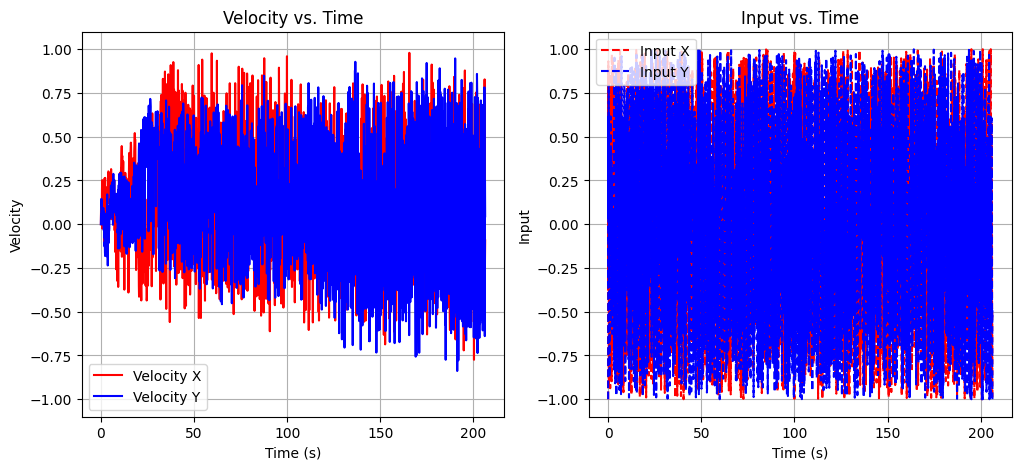

In [25]:
# Example 1: Modified Unsafe Regions
modified_unsafe = [
    [[0.5, -1, 2, -1], [1.5, 1, 3, 1]],
    [[2, -1, 0, -1], [3, 1, 1, 1]],
    [[2.5, -1, 3.5, -1], [3.5, 1, 4.5, 1]],
    [[4, -1, 1, -1], [5, 1, 2, 1]]
]
rrt1 = ReachAvoidStayRRT(x_init=[0, 0, 0, 0], K=1500, delta_q=0.1, 
                         unsafe_regions=modified_unsafe, target=original_target, 
                         tau=0.1, seed=42, example_name="Modified Unsafe Regions")
tree1 = rrt1.build_rrt()
rrt1.plot_tree_and_solution()
rrt1.plot_velocity_and_input()

C:\Users\zpy14\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


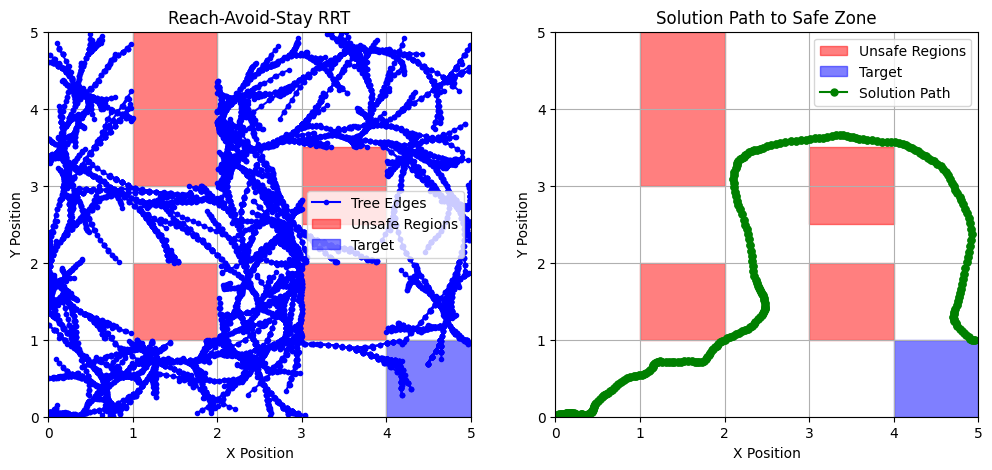

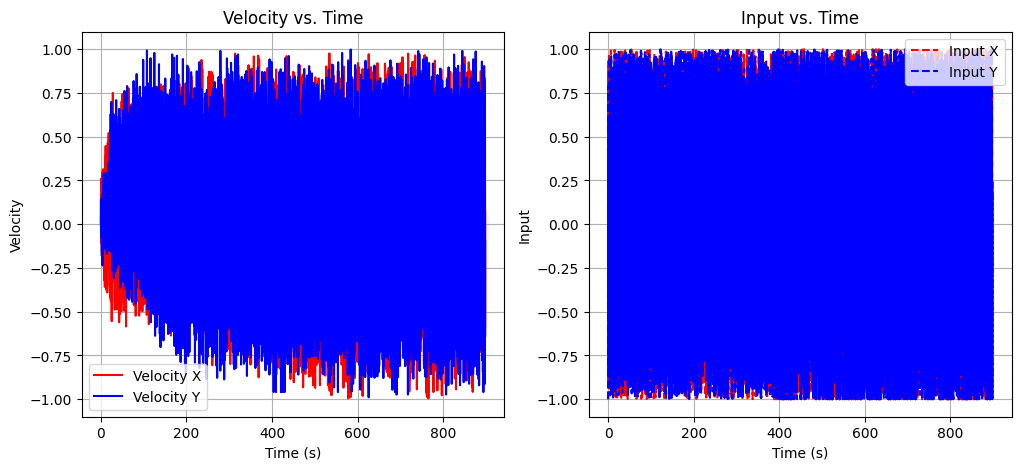

In [26]:
# Example 2: Modified Target Region (Bottom-Right Corner)
bottom_right_target = [[4, -0.1, 0, -0.1], [5, 0.1, 1, 0.1]]
rrt2 = ReachAvoidStayRRT(x_init=[0, 0, 0, 0], K=10000, delta_q=0.1, 
                         unsafe_regions=original_unsafe, target=bottom_right_target, 
                         tau=0.1, seed=42, example_name="Modified Target Region (Bottom-Right Corner)")
tree2 = rrt2.build_rrt()
rrt2.plot_tree_and_solution()
rrt2.plot_velocity_and_input()

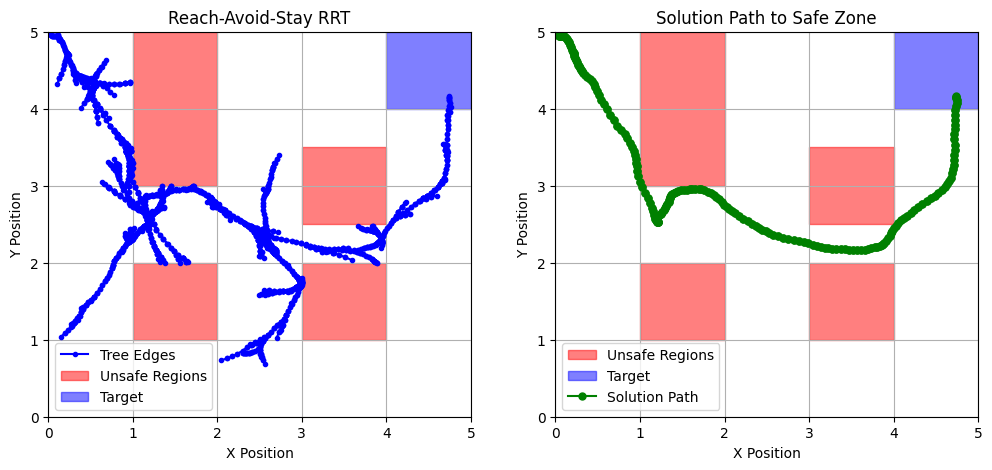

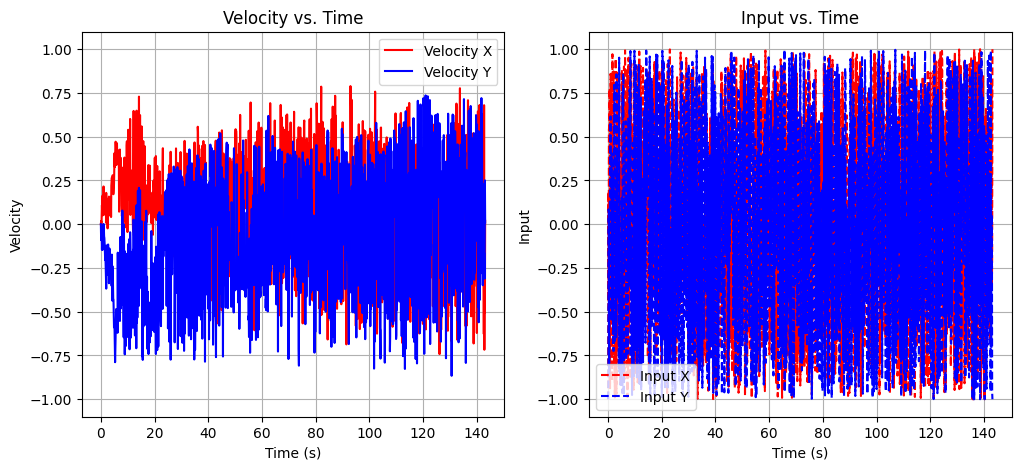

In [27]:
# Example 3: Modified Starting Position (Top-Left Corner)
top_left_start = [0, 0, 5, 0]
rrt3 = ReachAvoidStayRRT(x_init=top_left_start, K=1500, delta_q=0.1, 
                         unsafe_regions=original_unsafe, target=original_target, 
                         tau=0.1, seed=42, example_name="Modified Starting Position (Top-Left Corner)")
tree3 = rrt3.build_rrt()
rrt3.plot_tree_and_solution()
rrt3.plot_velocity_and_input()

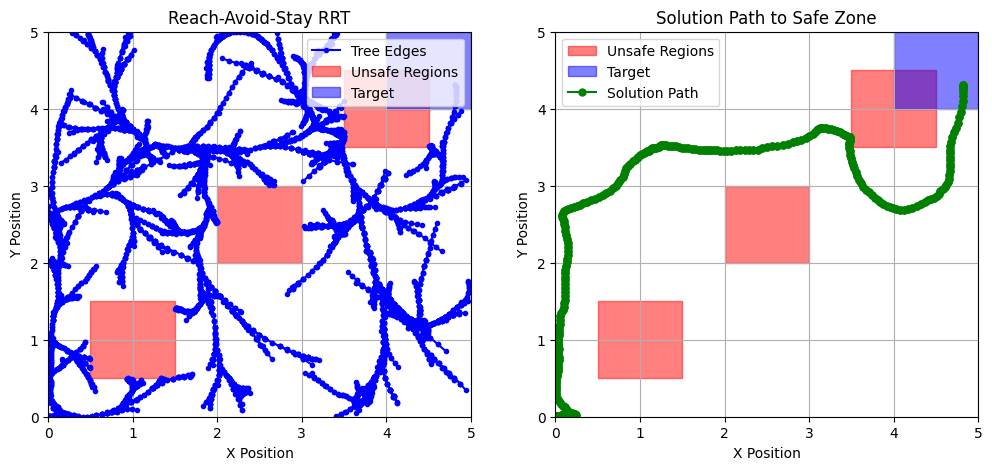

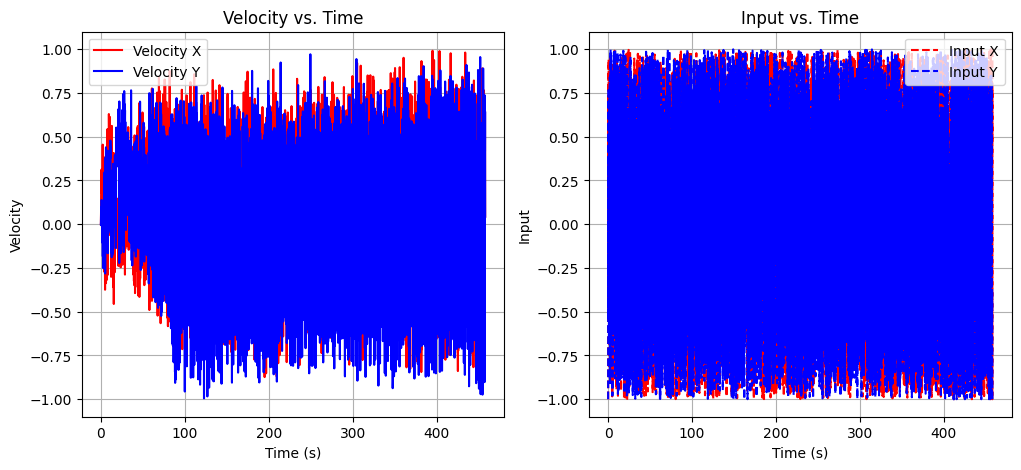

In [28]:
# Example where unsafe region slightly overlap with target
new_unsafe = [
    [[0.5, -1, 0.5, -1], [1.5, 1, 1.5, 1]],
    [[2, -1, 2, -1], [3, 1, 3, 1]],
    [[3.5, -1, 3.5, -1], [4.5, 1, 4.5, 1]]
]
new_target = [[4, -0.1, 4, -0.1], [5, 0.1, 5, 0.1]]
rrt_new = ReachAvoidStayRRT(x_init=[0, 0, 0, 0], K=3000, delta_q=0.1, 
                            unsafe_regions=new_unsafe, target=new_target, 
                            tau=0.1, seed=24, example_name="New Example")
tree_new = rrt_new.build_rrt()
rrt_new.plot_tree_and_solution()
rrt_new.plot_velocity_and_input()